## MODAL EVALUATION [WITH DYNAMIC THRESHOLDING]

In [50]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from insightface.app import FaceAnalysis
from sklearn.metrics import pairwise
from sklearn.metrics import (
    roc_curve, auc,
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)


###############################################################################
# 1) Prepare FaceAnalysis model
###############################################################################
# Using the buffalo_l model from insightface
model_name_dy ="buffalo_m"
# faceapp = FaceAnalysis(name='buffalo_l', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp = FaceAnalysis(name='buffalo_m', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='buffalo_s', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='buffalo_sc', root='insightface_model', providers=['CPUExecutionProvider'])
# faceapp = FaceAnalysis(name='antelopev2', root='insightface_model', providers=['CPUExecutionProvider'])
faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\det_2.5g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: insightface_model\models\buffalo_m\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [51]:
###############################################################################
# 2) Helper functions
###############################################################################
def clean_name(string):
    """
    Cleans the input string:
    - Removes non-alphabetic chars
    - Converts to Title case
    """
    string = re.sub(r'[^A-Za-z]', ' ', string)
    string = string.title()
    return string

def find_best_threshold(y_true, y_score):
    """
    Finds the threshold (0.00 to 1.00) that maximizes F1-score.
    Returns the (best_threshold, best_f1_score).
    """
    best_thr = 0.0
    best_f1 = 0.0
    # You can make this finer or coarser, e.g., np.linspace(0.0, 1.0, 101)
    for thr in np.linspace(0.0, 1.0, 101):
        y_pred_temp = (y_score >= thr).astype(int)
        f1_temp = f1_score(y_true, y_pred_temp, zero_division=0)
        if f1_temp > best_f1:
            best_f1 = f1_temp
            best_thr = thr
    return best_thr, best_f1

def save_model_results(model_name, y_true, y_pred, y_score, threshold, save_path='saved_results'):
    os.makedirs(save_path, exist_ok=True)
    results = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_score': y_score,
        'threshold': threshold
    }
    with open(os.path.join(save_path, f"{model_name}.pkl"), 'wb') as f:
        pickle.dump(results, f)

def load_all_model_results(save_path='saved_results'):
    all_results = {}
    for file in os.listdir(save_path):
        if file.endswith('.pkl'):
            model = file.replace('.pkl', '')
            with open(os.path.join(save_path, file), 'rb') as f:
                all_results[model] = pickle.load(f)
    return all_results


In [ ]:
###############################################################################
# 3) Build reference dataframe from 'images' folder
###############################################################################
person_info = []
listdir = os.listdir(path='images')

for folder_name in listdir:
    # Skip hidden/system folders that don't match 'role-name' format
    if '-' not in folder_name:
        print(f"Skipping folder (invalid format): {folder_name}")
        continue

    print(f"Processing folder: {folder_name}")
    role, name = folder_name.split('-', 1)  # split only once in case name has hyphens

    role = clean_name(role)
    name = clean_name(name)

    folder_path = os.path.join('images', folder_name)
    img_files = os.listdir(folder_path)

    for file in img_files:
        path = os.path.join(folder_path, file)

        # Step 1: Read the image
        img_arr = cv2.imread(path)
        if img_arr is None:
            print(f"Skipping invalid or unreadable image: {path}")
            continue

        # Step 2: Get face detection & embedding
        result = faceapp.get(img_arr, max_num=1)  # return lists
        if len(result) > 0:
            # Step 3: Extract facial embedding
            embedding = result[0]['embedding']
            # Step 4: Save name, role, and embedding
            person_info.append([name, role, embedding])
        else:
            print(f"No face detected in: {path}")

# Convert to DataFrame
dataframe = pd.DataFrame(person_info, columns=['Name', 'Role', 'Facial_Features'])
print("Reference dataframe created with shape:", dataframe.shape)
print(dataframe.head())


In [52]:
###############################################################################
# 3.5) Build reference dataframe from 'images' folder
###############################################################################

dataframe = pd.read_pickle("lfw_embeddings_{}.pkl".format(model_name_dy))
X_list = dataframe['Facial_Features'].tolist()
X = np.asarray(X_list)
dataframe

,Name,Role,Facial_Features
0,Aaron Peirsol,Student,"[-0.45143485, -1.6528509, 1.4327767, -0.422060..."
1,Aaron Peirsol,Student,"[-0.023353167, -1.446713, -0.01197511, 0.55963..."
2,Aaron Peirsol,Student,"[0.1924659, 0.27568585, 0.50092113, -0.3748789..."
3,Abdoulaye Wade,Student,"[-0.8208419, 0.2701584, -1.5315266, -0.8176923..."
4,Abdoulaye Wade,Student,"[0.23625141, -0.14451125, -1.2972999, -0.10191..."
...,...,...,...
1762,Zinedine Zidane,Student,"[0.8057942, 1.024703, 1.8526406, 0.23545212, -..."
1763,Zinedine Zidane,Student,"[0.19742373, 1.265694, 0.32113343, 0.16623753,..."
1764,Zoran Djindjic,Student,"[-0.6187218, -1.115498, 1.2926705, -0.69644, 0..."
1765,Zoran Djindjic,Student,"[-0.56719923, -0.68499243, 0.9995722, -1.31357..."


In [53]:
###############################################################################
# 4) Evaluate on test_folder
###############################################################################
root_folder = 'lfw_test'
total_images = 0

# For final metrics:
y_true = []   # 1 if correct match, 0 if incorrect
y_score = []  # confidence scores (cosine similarity)

for person_folder in os.listdir(root_folder):
    person_path = os.path.join(root_folder, person_folder)

    # If it's not a directory, skip
    if not os.path.isdir(person_path):
        continue

    # Clean up folder name (remove teacher/student)
    actual_name_cleaned = person_folder.lower()
    actual_name_cleaned = actual_name_cleaned.replace("student-", "")
    actual_name_cleaned = actual_name_cleaned.replace("teacher-", "")
    actual_name_cleaned = actual_name_cleaned.replace("_", " ")

    # Process images within that folder
    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)
        img_test = cv2.imread(image_path)

        if img_test is None:
            print(f"Skipping {image_path} (invalid image)")
            continue

        total_images += 1

        # Detect face(s) in the test image
        res_test = faceapp.get(img_test, max_num=0)
        if not res_test:
            print(f"No face detected in {image_name}")
            continue

        # We'll assume first face is the main face
        embed_test = res_test[0]['embedding'].reshape(1, -1)

        # Compute similarity to all reference embeddings
        cosine_similar = pairwise.cosine_similarity(X, embed_test).flatten()

        # Find best match
        best_match_index = np.argmax(cosine_similar)
        predicted_name = dataframe.loc[best_match_index]['Name'].lower()

        # Evaluate correctness: check if predicted is in "actual_name_cleaned"
        if predicted_name in actual_name_cleaned:
            y_true.append(1)
        else:
            y_true.append(0)

        # Save best-match score
        best_match_score = cosine_similar[best_match_index]
        y_score.append(best_match_score)

        print(f"Image: {image_name} → Predicted: {predicted_name}, "
              f"Actual: {actual_name_cleaned}, Score: {best_match_score:.4f}")


Image: Aaron_Peirsol_0003.jpg → Predicted: aaron peirsol, Actual: aaron peirsol, Score: 0.7824
Image: Abdoulaye_Wade_0004.jpg → Predicted: abdoulaye wade, Actual: abdoulaye wade, Score: 0.6993
Image: Abdullah_0003.jpg → Predicted: abdullah, Actual: abdullah, Score: 0.7140
Image: Abdullah_Gul_0002.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.8982
Image: Abdullah_Gul_0003.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7642
Image: Abdullah_Gul_0005.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7350
Image: Abdullah_Gul_0006.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7838
Image: Abdullah_Gul_0007.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7991
Image: Abdullah_Gul_0008.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.8131
Image: Abdullah_Gul_0009.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score: 0.7903
Image: Abdullah_Gul_0010.jpg → Predicted: abdullah gul, Actual: abdullah gul, Score

In [54]:
###############################################################################
# 4) Dynamic Threshold & Evaluation
###############################################################################

threshold_for_classification, _ = find_best_threshold(np.array(y_true), np.array(y_score))
y_pred = (np.array(y_score) >= threshold_for_classification).astype(int)
save_model_results(model_name_dy, y_true, y_pred, y_score, threshold_for_classification)


In [55]:
results_metric_dy = load_all_model_results()
results_metric_dy

{'antelopev2': {'y_true': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1

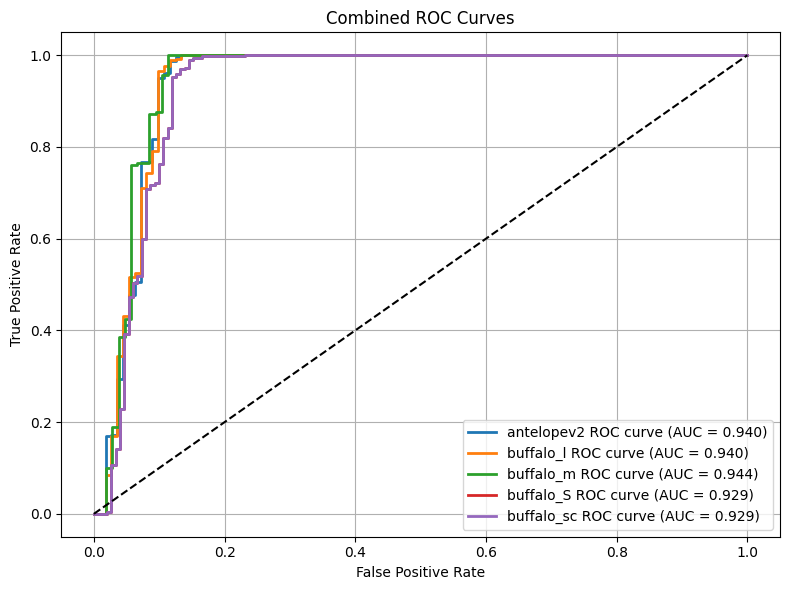

In [56]:
plt.figure(figsize=(8, 6))

for model, data in results_metric_dy.items():
    fpr, tpr, _ = roc_curve(data['y_true'], data['y_score'])
    roc_auc = auc(fpr, tpr)
    # plt.plot(fpr, tpr, label=f"{model} (AUC = {roc_auc:.2f})")
    plt.plot(fpr, tpr, label=f"{model} ROC curve (AUC = {roc_auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_roc_curve.png", dpi=300)
plt.show()



🔍 Model: antelopev2


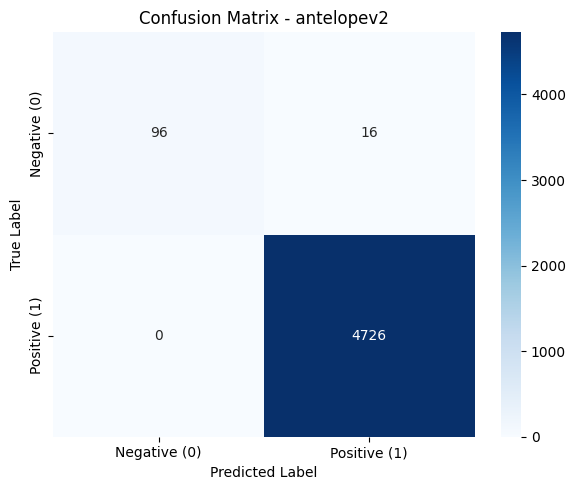

📄 Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.857     0.923       112
           1      0.997     1.000     0.998      4726

    accuracy                          0.997      4838
   macro avg      0.998     0.929     0.961      4838
weighted avg      0.997     0.997     0.997      4838


🔍 Model: buffalo_l


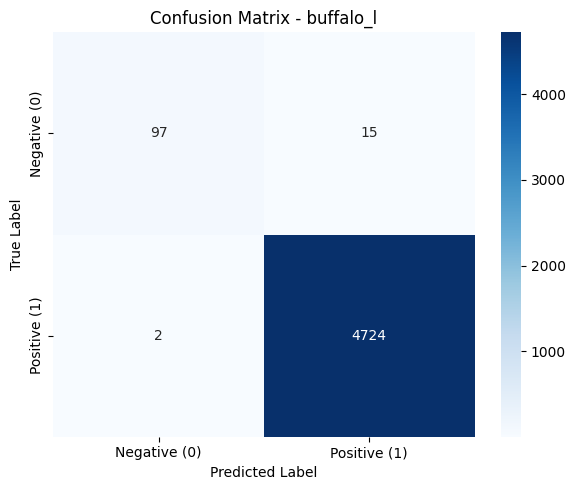

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.980     0.866     0.919       112
           1      0.997     1.000     0.998      4726

    accuracy                          0.996      4838
   macro avg      0.988     0.933     0.959      4838
weighted avg      0.996     0.996     0.996      4838


🔍 Model: buffalo_m


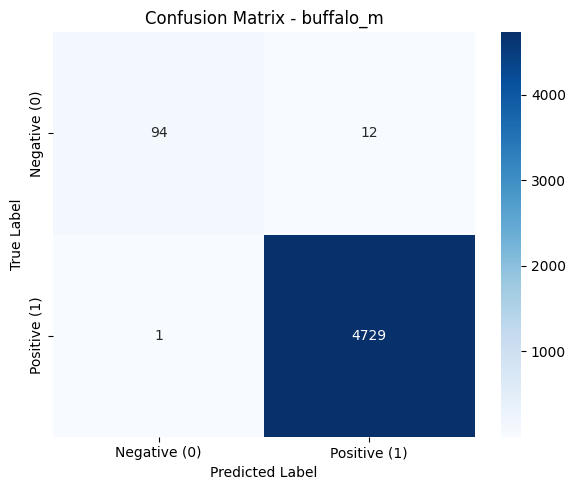

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.989     0.887     0.935       106
           1      0.997     1.000     0.999      4730

    accuracy                          0.997      4836
   macro avg      0.993     0.943     0.967      4836
weighted avg      0.997     0.997     0.997      4836


🔍 Model: buffalo_S


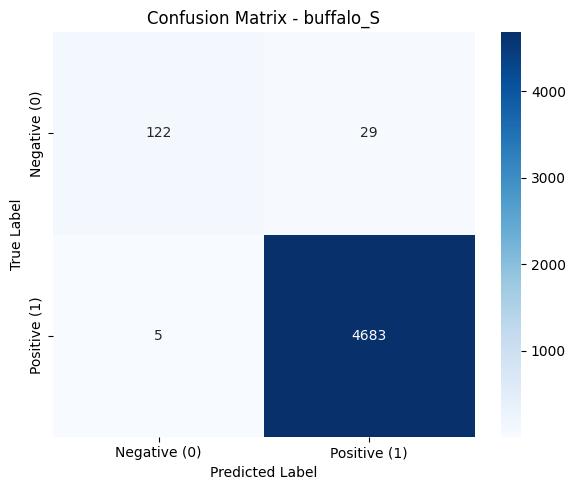

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.961     0.808     0.878       151
           1      0.994     0.999     0.996      4688

    accuracy                          0.993      4839
   macro avg      0.977     0.903     0.937      4839
weighted avg      0.993     0.993     0.993      4839


🔍 Model: buffalo_sc


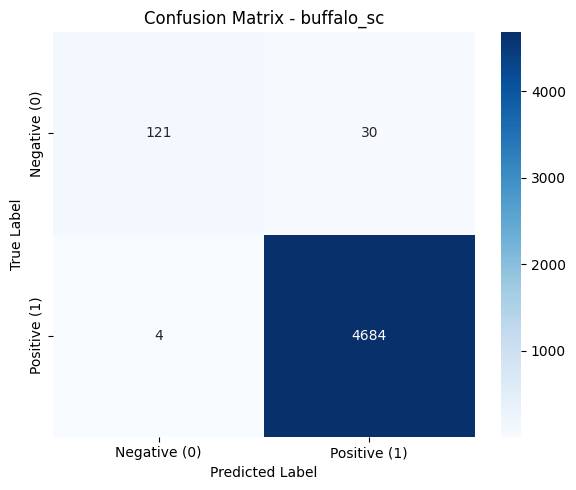

📄 Classification Report:
              precision    recall  f1-score   support

           0      0.968     0.801     0.877       151
           1      0.994     0.999     0.996      4688

    accuracy                          0.993      4839
   macro avg      0.981     0.900     0.937      4839
weighted avg      0.993     0.993     0.993      4839



In [57]:
# ----------------------------- Confusion Matrix + Report -----------------------------
for model, data in results_metric_dy.items():
    print(f"\n🔍 Model: {model}")
    
    y_true = data['y_true']
    y_pred = data['y_pred']

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Negative (0)', 'Positive (1)']
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{model}.png", dpi=300)
    plt.show()

    # Classification Report
    print("📄 Classification Report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))